# Evaluation of Learning rate vs. Weight decay experiments

We evaluate the effect of Learning rate (lr) and weight decay on the performance of ResNet18 and ConvNeXt$_{mini}$.  
Evaluation is done on the PhysioNet dataset.

In [56]:
from pathlib import Path
import torch
from torchmetrics.wrappers import BootStrapper

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import yaml
from tqdm import tqdm

from convnext_scaling.models.model_factory import MODELS
from convnext_scaling.models.module import LitModel
from convnext_scaling.datasets.physionet import PhysionetDM
from convnext_scaling.augmentations import ECGAugmentation
from convnext_scaling.metrics import scalar_metrics, PhysionetMetric
from convnext_scaling.datasets.physionet import CLASSES, SINUS_RYTHM, WEIGHTS

import numpy as np

sns.set_style("whitegrid")

In [2]:
def load_summary(summary: Path) -> dict:
    with summary.open(mode="r") as file:
        return json.load(file)

def load_config(path: Path) -> dict:
    with path.open(mode="r") as file:
        return yaml.safe_load(file)

def get_metadata_arg_value(metadata: Path, *keys):
    """Get key value pairs from the wandb-metadata.json 'args' field."""

    args_list = load_summary(metadata)["args"]

    result = {}
    for key in keys:
        try:
            index = args_list.index(key)
            result[key] = args_list[index + 1]  # Retrieve the value after the key
        except (ValueError, IndexError):
            result[key] = None  # Key not found or no value after key
    return result

### Data extraction from wandb logging

TODO: Run bottsrapping of loaded models.

In [19]:
# Extract all LR and WD parameters from the wandb-metadata.json files.
wandb_path = Path("../wandb")

df = []
for run in wandb_path.iterdir():
    if not run.name.startswith("run-2025"):
        continue
        
    config_file = run / "files" / "config.yaml"
    summary_file = run / "files" / "wandb-summary.json"
    
    if not config_file.is_file() or not summary_file.is_file():
        continue
    
    run_id = run.name.split("-")[-1]

    metadata = run / "files" / "wandb-metadata.json"
    summary = load_summary(run / "files" / "wandb-summary.json")
    _ = summary.pop("_wandb")

    args = get_metadata_arg_value(metadata, "--model.model_name", "--optimizer.lr", "--optimizer.weight_decay")
    args = {k.split(".")[-1]: v for k, v in args.items()} # Rename keys
        
    df.append({"run_id": run_id} | args | summary)

df = pd.DataFrame(df)

df.lr = df.lr.astype(float)
df.weight_decay = df.weight_decay.astype(float)

In [21]:
model_dir = Path("/sc-projects/sc-proj-gbm-radiomics/ecg/convnext-scaling/PhysioNetScaling")

In [45]:
ckpt_path = list((model_dir / df.sort_values("PhysioAccuracy", ascending=False).iloc[1].run_id).rglob("*.ckpt"))[0]

In [46]:
model = LitModel.load_from_checkpoint(ckpt_path)

In [57]:
def evaluate_model(model, model_name="", quantile=0.5, num_bootstraps=10):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    model = model.eval().to(device)

    # Metrics
    metrics = scalar_metrics()
    physiomet = PhysionetMetric(WEIGHTS, CLASSES, SINUS_RYTHM)
    bootstrap = BootStrapper(physiomet, num_bootstraps=num_bootstraps, quantile=quantile)

    # Dataset
    valid_transform = ECGAugmentation()
    train_transform = ECGAugmentation()
    dm = PhysionetDM("/sc-scratch/sc-scratch-gbm-radiomics/ecg/physionet_challenge/training_pt/metadata_v5.csv", train_transform=train_transform, val_transform=valid_transform, fold=0)
    dm.setup()
    dataloader = dm.val_dataloader()
    dataloader.num_workers = 32
    dataloader.prefetch_factor = 2

    # Evaluate
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(dataloader, total=len(dataloader), desc=model_name)):
            pred = model(x.to(device))
            pred, y = pred.cpu(), y.int().cpu()

            metrics(pred, y)
            bootstrap.update(pred, y)

    # Format output
    result = metrics.compute()
    for k, v in bootstrap.compute().items():
        result[f"PhysioAccuracy_{k}"] = v

    for k, v in result.items():
        result[k] = v.item()

    result["model_name"] = model_name
    
    return result

In [58]:
r = evaluate_model(model)

  0%|          | 0/828 [00:00<?, ?it/s]/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
 36%|███▋      | 301/828 [00:30<00:49, 10.71it/s]/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 828/828 [01:23<00:00,  9.93it/s]


In [59]:
r

{'AP': 0.5086999535560608,
 'AUROC': 0.9354801774024963,
 'Accuracy': 0.9548887610435486,
 'ECE': 0.17260366678237915,
 'F1': 0.491446852684021,
 'PhysioAccuracy': 0.7118747234344482,
 'Precision': 0.4503128230571747,
 'Recall': 0.5798249840736389,
 'PhysioAccuracy_mean': 0.7122976183891296,
 'PhysioAccuracy_std': 0.0020863511599600315,
 'PhysioAccuracy_quantile': 0.7124625444412231,
 'model_name': ''}

In [60]:
ckpt_path = list((model_dir / df.sort_values("PhysioAccuracy", ascending=False).iloc[0].run_id).rglob("*.ckpt"))[0]
model = LitModel.load_from_checkpoint(ckpt_path)
r = evaluate_model(model)

  0%|          | 0/828 [00:00<?, ?it/s]/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
 36%|███▋      | 301/828 [00:19<00:58,  9.01it/s]/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 828/828 [00:55<00:00, 15.04it/s]


In [61]:
r

{'AP': 0.5039489269256592,
 'AUROC': 0.9369064569473267,
 'Accuracy': 0.9498109221458435,
 'ECE': 0.1617174744606018,
 'F1': 0.4896291494369507,
 'PhysioAccuracy': 0.711499810218811,
 'Precision': 0.4147292971611023,
 'Recall': 0.6212684512138367,
 'PhysioAccuracy_mean': 0.711148202419281,
 'PhysioAccuracy_std': 0.002094402676448226,
 'PhysioAccuracy_quantile': 0.7107869982719421,
 'model_name': ''}

### Overall best performances

In [321]:
df[["model_name", "PhysioAccuracy", "F1", "Precision", "Recall", "AUROC"]].groupby("model_name").max()

,PhysioAccuracy,F1,Precision,Recall,AUROC
model_name,,,,,
convnext_mini,0.697085,0.225261,0.216634,0.268557,0.358347
resnet18,0.697501,0.224330,0.217623,0.265441,0.357906


In [322]:
# resnet18 performance - convnext performance
df[["model_name", "PhysioAccuracy", "F1", "Precision", "Recall", "AUROC"]].groupby("model_name").max().diff().iloc[-1]

PhysioAccuracy    0.000417
F1               -0.000931
Precision         0.000989
Recall           -0.003116
AUROC            -0.000441
Name: resnet18, dtype: float64

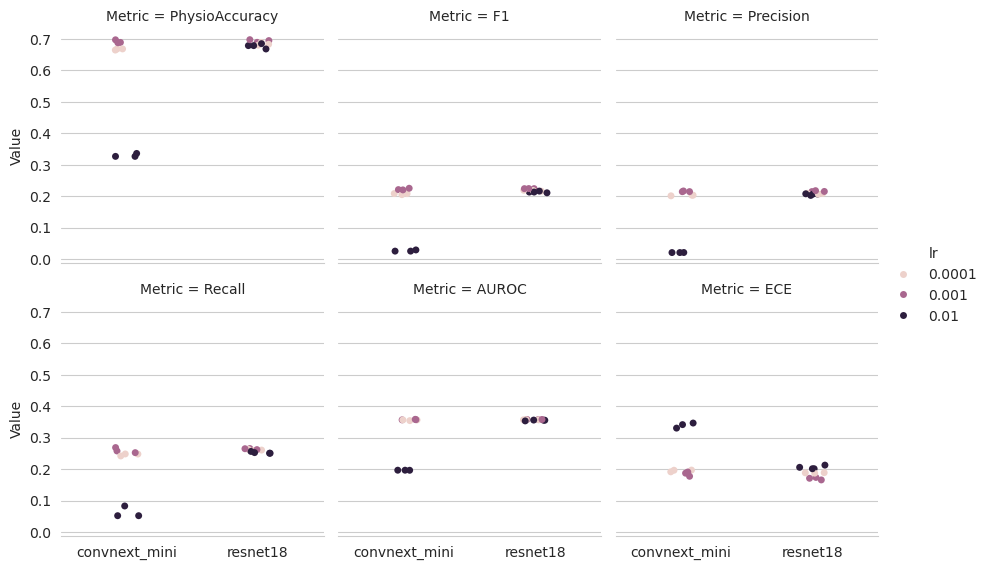

In [356]:
metric_df = df[
    [
        "model_name",
        "lr",
        "weight_decay",
        "PhysioAccuracy",
        "F1",
        "Precision",
        "Recall",
        "AUROC",
        "ECE",
    ]
].melt(
    id_vars=["model_name", "lr", "weight_decay"],
    var_name="Metric",
    value_name="Value",
)

g = sns.catplot(
    data=metric_df,
    x="model_name", y="Value", col="Metric", col_wrap=3, hue="lr", hue_norm=LogNorm(),
    kind="strip",
    height=3, aspect=1
)

g.set_axis_labels("", "Value")
g.despine(left=True)
plt.show()


## Feature importance

In [385]:
from sklearn.ensemble import RandomForestRegressor

def compute_feature_importance(data, feature_columns=["lr", "weight_decay"], target_column="F1", random_state=42):
    X = data[feature_columns]
    y = data[target_column]
    
    # Train a Random Forest model
    model = RandomForestRegressor(random_state=random_state)
    model.fit(X, y)
    
    # Get feature importances
    feature_importances = model.feature_importances_
    
    # Create a dictionary mapping feature names to importance scores
    importance_dict = dict(zip(feature_columns, feature_importances))
    
    return importance_dict


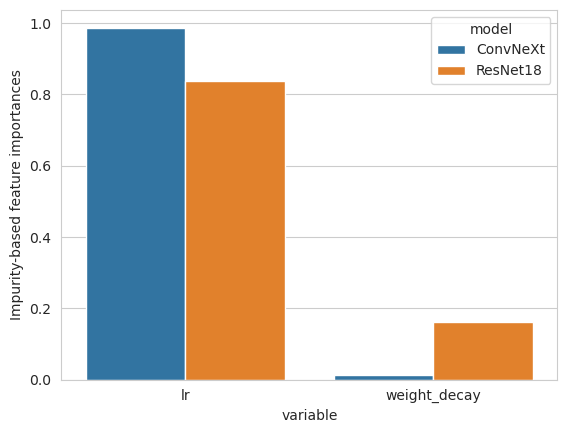

In [387]:
resnet_fi = compute_feature_importance(df[df.model_name == "resnet18"])
resnet_fi["model"] = "ResNet18"

convnext_fi = compute_feature_importance(df[df.model_name == "convnext_mini"])
convnext_fi["model"] = "ConvNeXt"

df_fi = pd.DataFrame([convnext_fi, resnet_fi]).melt(id_vars="model")


sns.barplot(df_fi, x="variable", y="value", hue="model")
plt.ylabel("Impurity-based feature importances")
plt.show()

In [381]:
df_fi

,model,variable,value
0,ConvNeXt,lr,1.800200
1,ResNet18,lr,1.243847
2,ConvNeXt,weight_decay,0.000469
3,ResNet18,weight_decay,0.102983


### Grid visualization

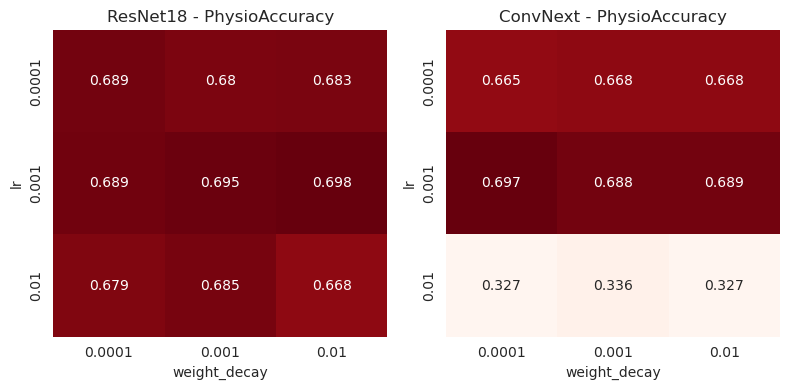

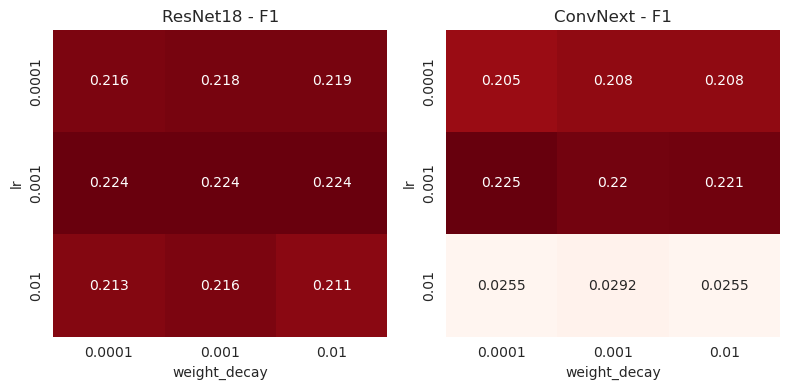

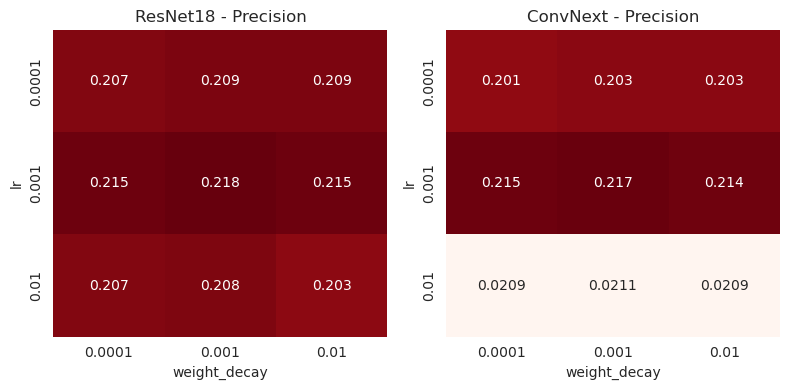

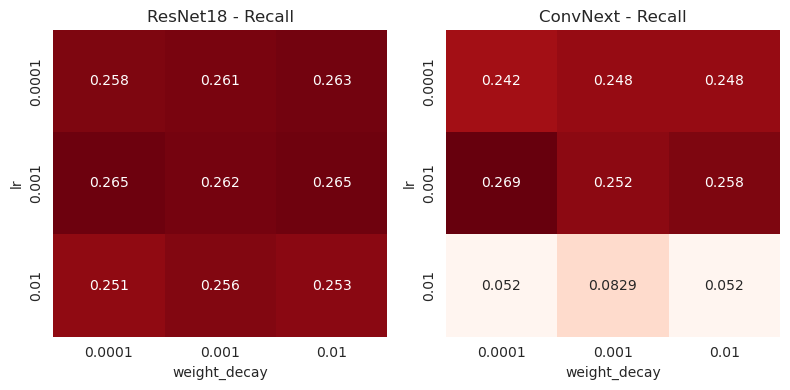

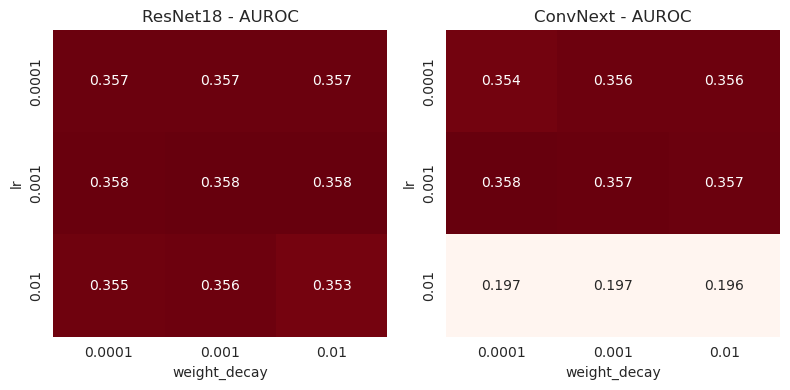

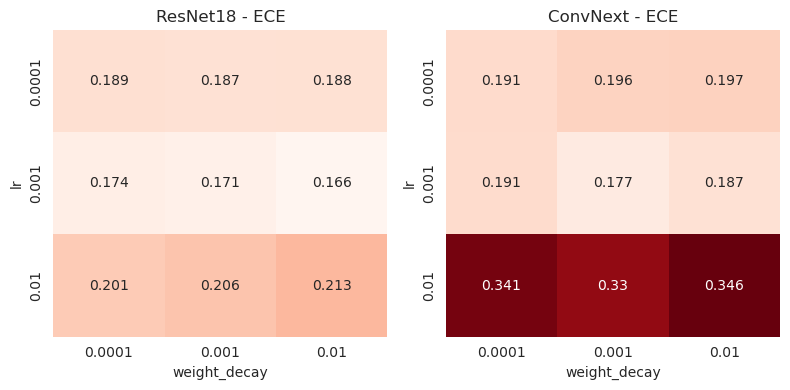

In [315]:
for metric in ["PhysioAccuracy", "F1", "Precision", "Recall", "AUROC", "ECE"]:
    
    
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    resnet = (
        df.loc[
            df.model_name == "resnet18", ["lr", "weight_decay", metric]
        ]
        .groupby(["lr", "weight_decay"], as_index=False)
        .mean()
        .pivot(index="lr", columns="weight_decay")[metric]
    )
    sns.heatmap(resnet, cmap="Reds", annot=True, fmt='.3g', vmin=df[metric].min(), vmax=df[metric].max(), ax=axs[0], cbar=False)
    axs[0].set_title(f"ResNet18 - {metric}")
    
    convnext = (
        df.loc[
            df.model_name == "convnext_mini",
            ["lr", "weight_decay", metric],
        ]
        .groupby(["lr", "weight_decay"], as_index=False)
        .mean()
        .pivot(index="lr", columns="weight_decay")[metric]
    )
    sns.heatmap(convnext, cmap="Reds", annot=True, fmt='.3g', vmin=df[metric].min(), vmax=df[metric].max(), ax=axs[1], cbar=False)
    axs[1].set_title(f"ConvNext - {metric}")
    
    plt.tight_layout()
    plt.show()

# Conclusion

1. Differences between model performances are small.
2. ConvNeXt has slight performance edge for best performing model.
3. Lr is more important than wd.
4. ResNet18 is more stable across lr and wd !!